<h1> Create Keras DNN model </h1>

This notebook illustrates:
<ol>
<li> Creating a model using Keras. This requires TensorFlow 2.0
</ol>

In [1]:
# change these to try this notebook out
# change these to try this notebook out
BUCKET = 'qwiklabs-gcp-03-042231f997f5'
PROJECT = '003-model-dnn-keras'
REGION = 'us-central1'

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [3]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

In [4]:
%%bash
ls *.csv

eval.csv
train.csv


## Create Keras model
<p>
First, write an input_fn to read the data.

In [ ]:
import shutil
import numpy as np
import tensorflow as tf
print(tf.__version__)

In [ ]:
# Determine CSV, label, and key columns
CSV_COLUMNS = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks,key'.split(',')
LABEL_COLUMN = 'weight_pounds'
KEY_COLUMN = 'key'

# Set default values for each CSV column. Treat is_male and plurality as strings.
DEFAULTS = [[0.0], ['null'], [0.0], ['null'], [0.0], ['nokey']]

In [ ]:
def features_and_labels(row_data):
    for unwanted_col in ['key']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(pattern, batch_size = 1, mode = tf.estimator.ModeKeys.EVAL):
  dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels) # features, label
             )
  if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.prefetch(1) # take advantage of multi-threading; 1 = AUTOTUNE
  return dataset

Next, define the feature columns. mother_age and gestation_weeks should be numeric.
The others (is_male, plurality) should be categorical.

In [ ]:
## Build a simple Keras DNN using its Functional API
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

# Helper function to handle categorical columns
def categorical_fc(name, values):
  return tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(name, values))

def build_dnn_model():
    # input layer
    inputs = {
        colname : tf.keras.layers.Input(name = colname, shape = (), dtype = 'float32')
           for colname in ['mother_age', 'gestation_weeks']
    }
    inputs.update({
        colname : tf.keras.layers.Input(name = colname, shape = (), dtype = 'string')
            for colname in ['is_male', 'plurality']        
    })

    # feature columns from inputs
    feature_columns = {
        colname : tf.feature_column.numeric_column(colname)
            for colname in ['mother_age', 'gestation_weeks']
    }

    # the constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires that you specify: LayerConstructor()(inputs)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(inputs)

    # two hidden layers of [64, 32] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(64, activation = 'relu', name = 'h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(32, activation = 'relu', name = 'h2')(h1)

    # final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation = 'linear', name = 'babyweight')(h2)
    

    model = tf.keras.models.Model(inputs, output)
    model.compile(optimizer = 'adam', loss = 'mse', metrics = [rmse, 'mse'])    
    return model

print("Here is our DNN architecture so far:\n")

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_dnn_model()
print(model.summary())

We can visualize the DNN using the Keras plot_model utility.

In [ ]:
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes = False, rankdir = 'LR')

## Train and evaluate

In [10]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 5  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset('train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('eval*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data = evalds,
                    epochs = NUM_EVALS, 
                    steps_per_epoch = steps_per_epoch)

Train for 312 steps, validate for 10 steps
Epoch 1/5
312/312 [==============================] - 6s 20ms/step - loss: 1.6076 - rmse: 1.2184 - mse: 1.6076 - val_loss: 1.3725 - val_rmse: 1.1710 - val_mse: 1.3725
Epoch 2/5
312/312 [==============================] - 2s 7ms/step - loss: 1.3184 - rmse: 1.1351 - mse: 1.3184 - val_loss: 1.2601 - val_rmse: 1.1220 - val_mse: 1.2601
Epoch 3/5
312/312 [==============================] - 2s 7ms/step - loss: 1.3208 - rmse: 1.1359 - mse: 1.3208 - val_loss: 1.2709 - val_rmse: 1.1268 - val_mse: 1.2709
Epoch 4/5
312/312 [==============================] - 2s 6ms/step - loss: 1.3374 - rmse: 1.1414 - mse: 1.3374 - val_loss: 1.3122 - val_rmse: 1.1449 - val_mse: 1.3122
Epoch 5/5
312/312 [==============================] - 2s 7ms/step - loss: 1.3242 - rmse: 1.1380 - mse: 1.3242 - val_loss: 1.4036 - val_rmse: 1.1841 - val_mse: 1.4036


## Visualize loss curve

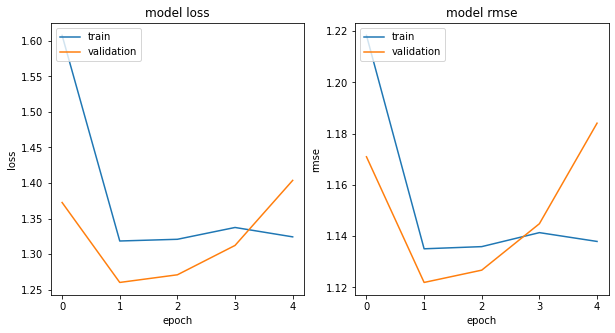

In [11]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize = (10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'upper left');

## Save the model

Let's wrap the model so that we can supply keyed predictions, and get the key back in our output

In [12]:
# Serving function that passes through keys
@tf.function(input_signature=[{
      'is_male': tf.TensorSpec([None,], dtype = tf.string, name = 'is_male'),
      'mother_age': tf.TensorSpec([None,], dtype = tf.float32, name = 'mother_age'),
      'plurality': tf.TensorSpec([None,], dtype = tf.string, name = 'plurality'),
      'gestation_weeks': tf.TensorSpec([None,], dtype = tf.float32, name = 'gestation_weeks'),
      'key': tf.TensorSpec([None,], dtype = tf.string, name = 'key')
}])
def my_serve(inputs):
    feats = inputs.copy()
    key = feats.pop('key')
    output = model(feats)
    return {'key': key, 'babyweight': output}

In [13]:
import shutil, os, datetime
OUTPUT_DIR = './export/babyweight'
shutil.rmtree(OUTPUT_DIR, ignore_errors = True)
EXPORT_PATH = os.path.join(OUTPUT_DIR, datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
tf.saved_model.save(model, EXPORT_PATH, signatures = {'serving_default': my_serve})
print("Exported trained model to {}".format(EXPORT_PATH))
os.environ['EXPORT_PATH'] = EXPORT_PATH

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./export/babyweight/20200503023018/assets
Exported trained model to ./export/babyweight/20200503023018


In [14]:
!find $EXPORT_PATH

./export/babyweight/20200503023018
./export/babyweight/20200503023018/variables
./export/babyweight/20200503023018/variables/variables.data-00000-of-00001
./export/babyweight/20200503023018/variables/variables.index
./export/babyweight/20200503023018/assets
./export/babyweight/20200503023018/saved_model.pb


<h2> Monitor and experiment with training </h2>

In TensorBoard, look at the learned embeddings. Are they getting clustered? How about the weights for the hidden layers? What if you run this longer? What happens if you change the batchsize?

## Deploy trained model to Cloud AI Platform


In [ ]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir {EXPORT_PATH}

In [ ]:
%%bash
MODEL_NAME = "babyweight"
VERSION_NAME = "dnn"
MODEL_LOCATION = $EXPORT_PATH
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"

if [[ $(gcloud ai-platform models list --format = 'value(name)' | grep $MODEL_NAME) ]]; then
    echo "The model named $MODEL_NAME already exists."
else
    # create model
    echo "Creating $MODEL_NAME model now."
    gcloud ai-platform models create --regions = $REGION $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --model $MODEL_NAME --format = 'value(name)' | grep $VERSION_NAME) ]]; then
    echo "Deleting already the existing model $MODEL_NAME:$VERSION_NAME ... "
    gcloud ai-platform versions delete --model = $MODEL_NAME $VERSION_NAME
    echo "Please run this cell again if you don't see a Creating message ... "
    sleep 2
fi

# create model
echo "Creating $MODEL_NAME:$VERSION_NAME"
gcloud ai-platform versions create --model = $MODEL_NAME $VERSION_NAME --async \
       --framework = tensorflow --python-version = 3.5 --runtime-version = 1.14 \
       --origin = $MODEL_LOCATION --staging-bucket=gs://$BUCKET

Monitor the model creation at [GCP Console > AI Platform](https://console.cloud.google.com/mlengine/models/taxifare/) and once the model version `dnn` is created, proceed to the next cell.


In [17]:
%%writefile input.json
{"key": "b1", "is_male": "True", "mother_age": 26.0, "plurality": "Single(1)", "gestation_weeks": 39}
{"key": "b2", "is_male": "True", "mother_age": 33.0, "plurality": "Single(1)", "gestation_weeks": 41}
{"key": "g1", "is_male": "False", "mother_age": 26.0, "plurality": "Single(1)", "gestation_weeks": 39}
{"key": "g2", "is_male": "False", "mother_age": 33.0, "plurality": "Single(1)", "gestation_weeks": 41}

Writing input.json


In [18]:
!gcloud ai-platform predict --model babyweight --json-instances input.json --version dnn

ERROR: (gcloud.ai-platform.predict) NOT_FOUND: Field: name Error: The model resource: "babyweight" was not found. Please create the Cloud ML model resource first by using 'gcloud ml-engine models create babyweight'.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: "The model resource: \"babyweight\" was not found. Please create\
      \ the Cloud ML model resource first by using 'gcloud ml-engine models create\
      \ babyweight'."
    field: name


## main.py

This is the code that exists in [serving/application/main.py](serving/application/main.py), i.e. the code in the web application that accesses the ML API.

In [ ]:
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery

credentials = GoogleCredentials.get_application_default()
api = discovery.build('ml', 'v1', credentials=credentials)
project = PROJECT
model_name = 'babyweight'
version_name = 'dnn'

input_data = {
  'instances': [
    {
      'key': 'b1',
      'is_male': 'True',
      'mother_age': 26.0,
      'plurality': 'Single(1)',
      'gestation_weeks': 39
    },
    {
      'key': 'g1',
      'is_male': 'False',
      'mother_age': 29.0,
      'plurality': 'Single(1)',
      'gestation_weeks': 38
    },
    {
      'key': 'b2',
      'is_male': 'True',
      'mother_age': 26.0,
      'plurality': 'Triplets(3)',
      'gestation_weeks': 39
    },
    {
      'key': 'u1',
      'is_male': 'Unknown',
      'mother_age': 29.0,
      'plurality': 'Multiple(2+)',
      'gestation_weeks': 38
    },
  ]
}

parent = 'projects/%s/models/%s/versions/%s' % (project, model_name, version_name)
prediction = api.projects().predict(body = input_data, name = parent).execute()
print(prediction)
print(prediction['predictions'][0]['babyweight'][0])